In [1]:
import wikipedia
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [12]:
philosophy = wikipedia.page('philosophy')

G = nx.Graph()
G.add_node("philosophy")
phil_page = False
page_links = philosophy.links
old_page = "philosophy"

while not phil_page:
    first_link = page_links[0]
    print(first_link)
    G.add_node(first_link)
    G.add_edges_from(old_page, first_link)

    if first_link.lower() == "philosophy":
        phil_page == True

    else:
        first_link_page = wikipedia.page(first_link)
        page_links = first_link_page.links
        old_page = first_link

    



Abortion


TypeError: Graph.add_edges_from() takes 2 positional arguments but 3 were given

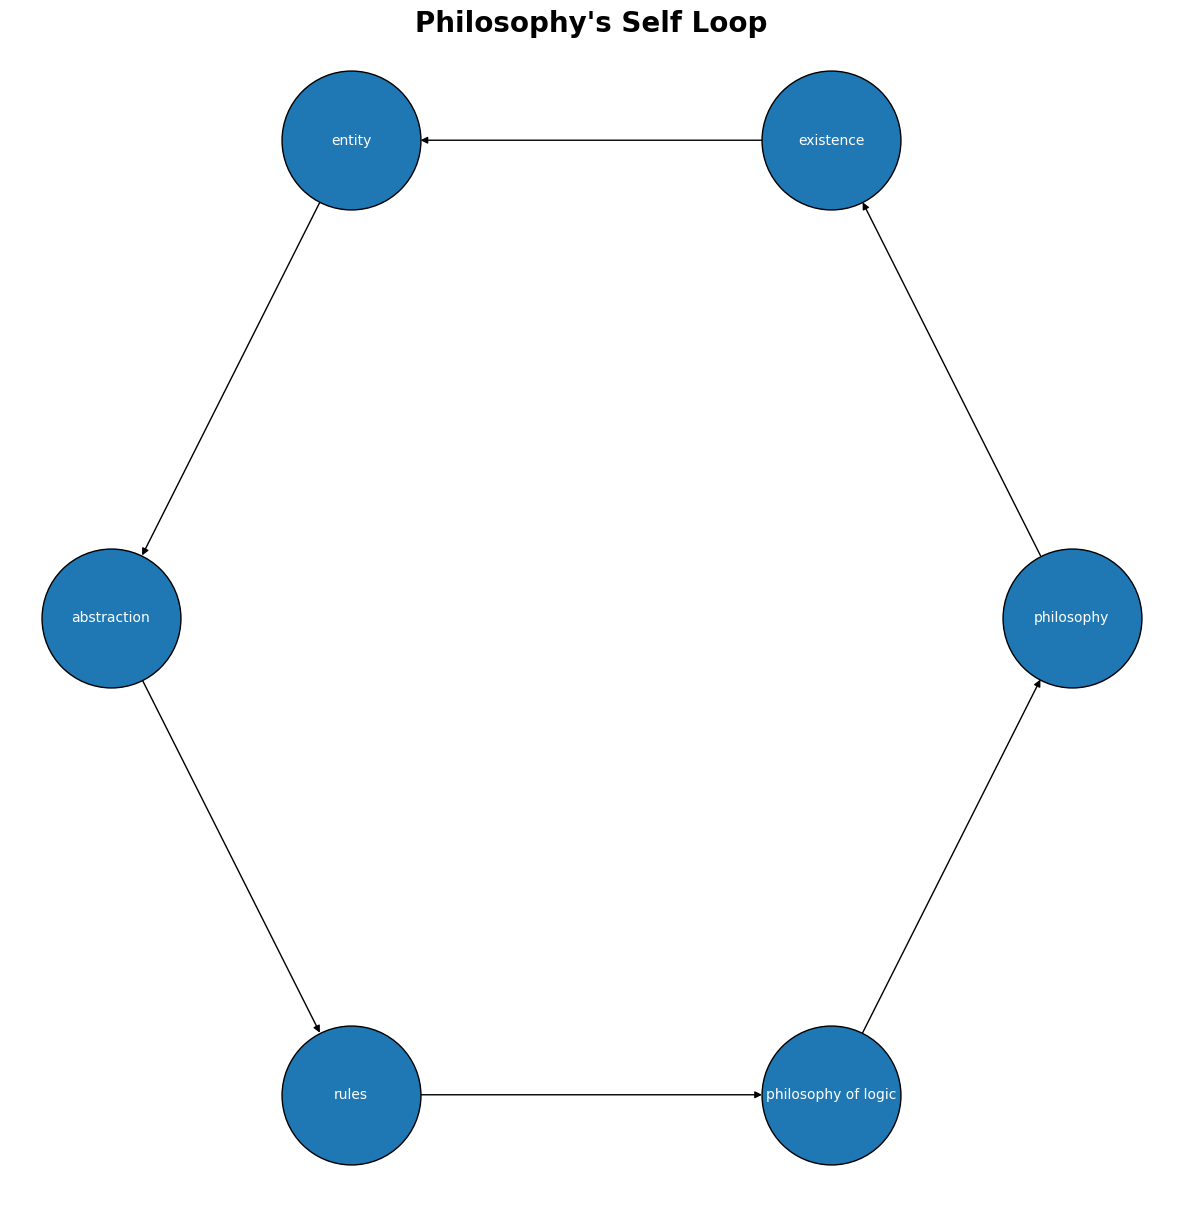

In [40]:
path = ['philosophy','existence', 'entity', 'abstraction', 'rules', 'philosophy of logic', 'philosophy']
G = nx.DiGraph()

for i, page_name in enumerate(path):
    G.add_node(page_name)
    if i == 0:
        pass
    else: 
        G.add_edge(old_page, page_name)
        old_page = page_name

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)

pos = nx.circular_layout(G)
fig = nx.draw(G,
    with_labels=True,
    edgecolors="black",
    font_color="white",
    node_size=10000,
    pos=pos,
    font_size=10) 

plt.title("Philosophy's Self Loop", fontweight='bold', fontsize=20)
plt.savefig('../slides/Images/phil-loop.png')
plt.show()